<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 2 </center></h3>
<h4><center> Group Number: 05 </center></h4>

<h4><center> Group Member 1: Zhou Yunong, A0194565R </center></h4>
<h4><center> Group Member 2: Zhang Jingyuan, A0190119J </center></h4>
<h4><center> Group Member 3: Zhang Manman, A0194543Y </center></h4>
<h4><center> Group Member 4: Zhu Qianqian, A0188076R </center></h4>

In [ ]:
import jax
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import numpy as np
import pylab as plt
from numpy.linalg import norm

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.extmath import randomized_svd

In [ ]:
# importing the necessary libraries
#from surprise import Reader, Dataset
from scipy.sparse import csr_matrix
from datetime import datetime
from scipy import sparse
#from surprise import Reader, Dataset,SVD
from sklearn.utils.extmath import randomized_svd

In [ ]:
# 删掉
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

In [ ]:
#User information
unames = ['user_id','gender','age','occupation','zip']
users = pd.read_table("users.dat", sep='::',
                      header=None, names=unames, engine='python')
#Rating information
rnames = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_table("ratings.dat", sep='::', header=None, names=rnames, engine='python')
#Movie information
mnames = ['movie_id','title','genres']
movies = pd.read_table("movies.dat", sep='::', header=None, names=mnames, engine='python',encoding='ISO-8859-1')

In [ ]:
print(ratings.shape)
print(users.shape)
print(movies.shape)

(1000209, 4)
(6040, 5)
(3883, 3)


In [ ]:
#training: 90%, testing: 10%
train,test = train_test_split(ratings, test_size=0.1)

In [ ]:
def train_test_matrix(train, test):
    """
    build the corresponding rating matrix, A for train and test data
    """
    n_user = ratings.user_id.nunique()+1
    #n_movie = ratings.movie_id.nunique()
    n_movie = max(ratings['movie_id'])+1
    train,test = train_test_split(ratings, test_size=0.1)

    #fill up the matrices
    def func1(x):
        A_train[x[0],x[1]] = x[2]
        return x
    def func2(x):
        A_test[x[0],x[1]] = x[2]
        return x
    A_train = np.zeros((n_user, n_movie))
    A_test = np.zeros((n_user, n_movie))
    train.apply(func1, axis=1)
    test.apply(func2,axis=1)
    return A_train, A_test

In [ ]:
#train and test matrix
A_train,A_test = train_test_matrix(train, test)

###Baseline model using global mean

In [ ]:
#convert from df to array to allow jax
train_base = np.array(A_train)
test_base = np.array(A_test)

In [ ]:
def RMSE(y_true,y_pred,index):
    error = y_true[index] - y_pred[index]
    return jnp.sqrt(jnp.mean(error**2))

In [ ]:
# train rmse
index_train_base = np.nonzero(train_base)
mu = train_base[index_train_base].mean()
y_pred_train = np.full((train_base.shape[0], train_base.shape[1]), mu)
train_rmse = RMSE(train_base, y_pred_train,index_train_base)
train_rmse

DeviceArray(1.11701321, dtype=float64)

In [ ]:
# test rmse
index_test_base = np.nonzero(test_base)
y_pred_test = np.full((test_base.shape[0], test_base.shape[1]), mu)
test_rmse = RMSE(test_base, y_pred_test,index_test_base)
test_rmse

DeviceArray(1.11789375, dtype=float64)

In [ ]:
print("Train RMSE is : {} and Test RMSE : {}".format(train_rmse,test_rmse))

Train RMSE is : 1.1170132088569187 and Test RMSE : 1.1178937512236475


#Matrix Factorization

### Naive Matrix Factorization

In [ ]:
A = A_train

In [ ]:
#RMSE function
index = np.nonzero(A)
@jax.jit
def RMSE(U,V,A):
    UV = U @ V
    #scalisation
    min_num = np.min(UV)
    UV = UV - min_num
    max_num = np.max(UV)
    uv = (UV/max_num)*4 + 1
    error = A[index] - uv[index]
    return jnp.sqrt(jnp.mean(error**2))

RMSE_grad_u = jax.jit( jax.grad(RMSE, argnums=0) )
RMSE_grad_v = jax.jit( jax.grad(RMSE, argnums=1) )

#initialise dimensions
m,n = A.shape
m,n
r=15
U_init = np.random.normal(0,1,size=(m,r))
V_init = np.random.normal(0,1,size=(r,n))
grad_u = RMSE_grad_u(U_init,V_init,A)
grad_v = RMSE_grad_v(U_init,V_init,A)

U,V = np.copy(U_init), np.copy(V_init)

In [ ]:
# parallel update of parameters
niter = 200
learning_rate = 0.5
beta = 0.02
trainLoss_history = []
testLoss_history = []
testRow = test.shape[0]
for _ in range(niter):
    # compute the gradients
    grad_u = RMSE_grad_u(U,V,A)
    grad_v = RMSE_grad_v(U,V,A)

    # do the gradient updates
    U = U - learning_rate * (grad_u + beta*U)
    V = V - learning_rate * (grad_v + beta*V)

    # check the loss for monitoring purposes
    train_loss = RMSE(U,V,A)
    test_loss = RMSE(U,V,A_test)
    trainLoss_history.append(train_loss)
    testLoss_history.append(test_loss)


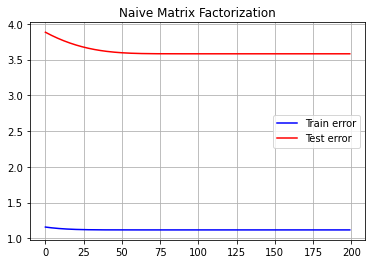

In [ ]:
plt.plot(trainLoss_history, color = "blue",label = "Train error")
plt.plot(testLoss_history, color = "red",label = "Test error")
plt.legend(loc= "best")
plt.title("Naive Matrix Factorization")
plt.grid()

In [ ]:
train_rmse = min(trainLoss_history)
test_rmse = min(testLoss_history)
print("Train RMSE is : {} and Test RMSE : {}".format(train_rmse,test_rmse))

Train RMSE is : 1.1170065458645566 and Test RMSE : 3.5814364763118487


### Non-negative Matrix Factorization

In [ ]:
n_item = movies.shape[0]
n_user = users.shape[0]
print('user id starts from %d and item id starts from %d'%(users.user_id.describe()['min'],
                                                          movies.movie_id.describe()['min']) )

user id starts from 0 and item id starts from 0


In [ ]:
# indexing userid, movieid from 0
movies['movie_id'] = movies['movie_id'].apply(lambda x: x - 1)
users['user_id'] = users['user_id'].apply(lambda x: x - 1)
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: x - 1)
ratings['user_id'] = ratings['user_id'].apply(lambda x: x - 1)

Rating Matrix:


$$A^{user\hspace{1mm} \times \hspace{1mm}movie}$$


Low Rank Matrix:

$$U^{user\hspace{1mm} \times \hspace{1mm}rank}$$

$$V^{movie\hspace{1mm} \times \hspace{1mm}rank}$$

$$\text{𝑤ℎ𝑒𝑟𝑒 𝑟𝑎𝑛𝑘 = 𝑛}$$

#### matrix factorizer

In [ ]:
class MF:
    """
    Matrix factorization class.
    """
    def __init__(self,lambda1 = 0.01, learning_rate=0.001, max_iteration=10000, rank=10, verbose=True, gap=None):
        """
        params
        ------
        lambda1: float. Regularizer parameter.

        learning_rate: float. Learning rate of SGD

        max_iteration: int.

        rank: int. Embedding dimension of the U,V matrix where A = U.V

        verbose: bool. Whether to print iteration log or not.

        gap: bool.
            Gap between each iteration log when verbose is true. Default value is 10th factor of max_iteration.
        """
        self.lambda1 = lambda1
        self.learning_rate = learning_rate
        self.max_iteration = max_iteration
        self.rank = rank
        self.verbose = verbose
        self.gap = gap
        self.U = None
        self.V = None
        self.gap = (max_iteration / 10) if gap is None else gap


    def rmse(self, actual, pred):
        """Returns the rmse of nonzero errors"""
        for a in range(0,pred.shape[0]):
            for b in range(0,pred.shape[1]):
                if pred[a][b] > 5:
                    pred[a][b] = 5
                elif pred[a][b] < 1:
                    pred[a][b] = 1
        pred = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        return mean_squared_error(actual, pred, squared=False)


    def predict(self,query_embedding,name='Aladdin',measure='cosine'):
        """
        params
        ------
        query_embedding: 1D array.
            Query's embeddding vector. For example if we want to find similar movies like Aladdin,
            query_embedding will be Aladdin's vector from V.
        V: array-like. 2d. Item embedding.
        name: str. Movie name.
        measure: {dot,cosine}
            similarity measure for query and V.

        returns
        -------
        sim_vector: similarity vector between query_embedding and V.
        """
        u = query_embedding
        V = self.V
        if measure == 'cosine':
            V = V / np.linalg.norm(V, axis=1, keepdims=True)
            u = u / np.linalg.norm(u)
        sim_vector = u.dot(V.T)
        return sim_vector


    def SGD(self,A,rated_rows,rated_cols,A_test=None):
        """
        params
        ------
        A: 2D array. shape(n_user,n_item)
            Training rating matrix.

        rated_rows: 1D array.
            Observed indices rows from A. Meaning i where A_{i,j} > 0.

        rated_cols: 1D array.
            Observed indices' column from A. Meaning j where A_{i,j} > 0.

        """
        self.history= []
        for itr in range(self.max_iteration):
            # choosing an observed user,movie combination
            u = np.random.choice(rated_rows)
            m = np.random.choice(rated_cols)
            #forward pass
            error = A[u,m] - np.dot(self.U[u], self.V[m])
            # backward pass
            tmp = self.U[u]
            self.U[u] = self.U[u] + self.learning_rate * (error * self.V[m] - self.lambda1 * self.U[u])
            self.V[m] = self.V[m] + self.learning_rate * (error * tmp - self.lambda1 * self.V[m])

            if (itr % self.gap) == 0 or itr == self.max_iteration - 1:
                A_hat = np.dot(self.U,self.V.T)
                train_rmse = self.rmse(A,A_hat)
                test_rmse = -1
                if isinstance(A_test,np.ndarray):
                    test_rmse = self.rmse(A_test,A_hat)
                self.history.append((train_rmse,test_rmse))
                if self.verbose==True:
                    print("iteration %d, TrainRMSE: %.2f TestRMSE: %.2f"%
                          (itr,train_rmse,test_rmse))

    def fit(self,A,A_test=None):
        """
        Fit the U,V to A.
        """
        rated_rows,rated_cols = A.nonzero()
        n_user = A.shape[0]
        n_movie = A.shape[1]
        if self.U is None:
            self.U = np.random.rand(n_user,self.rank)
            self.V = np.random.rand(n_movie,self.rank)

        # used in verbose mode
        self.SGD(A,rated_rows,rated_cols,A_test)

    def graph(self,testset=False):
        """
        Training and test graph with other meta data.
        """
        fig, ax = plt.subplots(facecolor='white',figsize=(10,5))
        train = [w[0] for w in self.history]
        test = [w[1] for w in self.history]
        x = list(range(0,self.max_iteration+2,int(self.gap)))
        ax.plot(x,train,color='red',label='Train RMSE')
        if testset==True:
            ax.plot(x,test,color='green',label='Test RMSE')
        ax.legend()
        ax.grid(True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("RMSE")
        caption = f'lambda: {lambda1} learning_rate: {self.learning_rate} iteration: {self.max_iteration}'
        plt.title(caption)
        plt.show()

####model fitting

iteration 0, TrainRMSE: 1.80 TestRMSE: 1.80
iteration 15000, TrainRMSE: 1.79 TestRMSE: 1.79
iteration 30000, TrainRMSE: 1.77 TestRMSE: 1.77
iteration 45000, TrainRMSE: 1.73 TestRMSE: 1.73
iteration 60000, TrainRMSE: 1.68 TestRMSE: 1.68
iteration 75000, TrainRMSE: 1.63 TestRMSE: 1.64
iteration 90000, TrainRMSE: 1.60 TestRMSE: 1.61
iteration 105000, TrainRMSE: 1.59 TestRMSE: 1.59
iteration 120000, TrainRMSE: 1.58 TestRMSE: 1.59
iteration 135000, TrainRMSE: 1.58 TestRMSE: 1.59
iteration 149999, TrainRMSE: 1.60 TestRMSE: 1.61


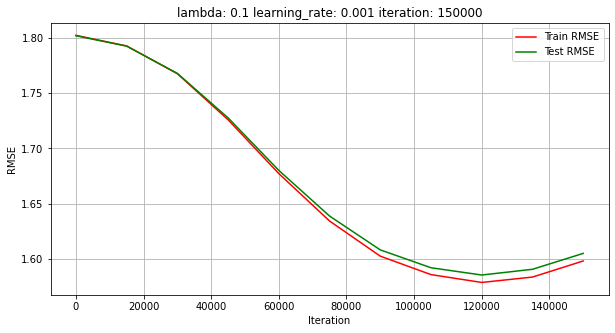

In [ ]:
lambda1 = 0.1
lr = 0.001
max_iter = 150000
gap = max_iter / 10
view = True

model = MF(lambda1, learning_rate=lr, max_iteration=max_iter, rank=30, verbose=True)
model.fit(A_train, A_test)
model.graph(testset=True)

### Probabilistic Matrix Factorization

In [ ]:
m= A_train.shape[0]
n= A_train.shape[1]
r=10 #
sig_U = np.sqrt(5)
sig_V = np.sqrt(5)
U_init = np.random.normal(0,sig_U,size=(m,r))
V_init = np.random.normal(0,sig_V,size=(r,n))



In [ ]:
def loss(U,V,A,index):
  #UV = U @ V
  #l1 = jnp.mean(0.5*(A[index]-(U@V)[index])**2 )
  #l2 = jnp.mean( (U.T @ U) )
  #l3 = jnp.mean( (V.T @ V) )
  R = A[index]
  lam_U = 0.01
  lam_V = 0.01
  return jnp.mean(0.5*(R-(U@V)[index])**2 ) + lam_U*jnp.mean( (U.T @ U) ) + lam_V*jnp.mean( (V.T @ V) )

In [ ]:
loss_grad_u = jax.jit( jax.grad(loss, argnums=0) )
loss_grad_v = jax.jit( jax.grad(loss, argnums=1) )

In [ ]:
def RMSE(U,V,A,index):
    UV = U @ V
    error = A[index] - UV[index]
    return jnp.sqrt(jnp.mean(error**2))

In [ ]:
# sequential update of parameters
def run_GD(U,V,A_train,A_test):
    index_train = np.nonzero(A_train)
    index_test = np.nonzero(A_test)
    niter = 1000
    learning_rate = 10 #1
    loss_train_history = []
    loss_test_history = []

    for _ in range(niter):

      grad_u= loss_grad_u(U,V,A_train,index_train)
      U = U - learning_rate * grad_u

      grad_v = loss_grad_v(U,V,A_train,index_train)
      V = V - learning_rate * grad_v

    # check the loss for monitoring purposes
      current_loss_train = RMSE(U,V,A_train,index_train)
      current_loss_test = RMSE(U,V,A_test, index_test)

      loss_train_history.append(current_loss_train)
      loss_test_history.append(current_loss_test)

    return loss_train_history,loss_test_history


In [ ]:

loss_train, loss_test = run_GD(U_init,V_init,A_train,A_test)


Text(0.5, 1.0, 'Probabilistic Matrix Factorization')

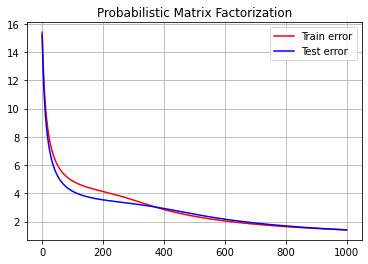

In [ ]:
plt.plot(loss_train,color = "red", label = "Train error")
plt.plot(loss_test,color = "blue", label = "Test error")
plt.legend(loc= "best")
plt.grid()
plt.title("Probabilistic Matrix Factorization")

In [ ]:
train_rmse = min(loss_train)
test_rmse = min(loss_test)
print("Train RMSE is : {} and Test RMSE : {}".format(train_rmse,test_rmse))

Train RMSE is : 1.406653331282011 and Test RMSE : 1.4045289832221766


##Singular Value Decomposition

In [ ]:
train_data, test_data = train, test

In [ ]:
# creating sparse matrix representation our dataframes
test_sparse_matrix = sparse.csr_matrix((test_data.rating.values, (test_data.user_id.values,
                                               test_data.movie_id.values)))

train_sparse_matrix = sparse.csr_matrix((train_data.rating.values, (train_data.user_id.values,
                                               train_data.movie_id.values)))

In [ ]:
# methods to compute gradients
def derivative_db(user_id,item_id,rating,U,V,mu,alpha, b_i, c_j):
    '''In this function, we will compute dL/db_i'''
    loss =  (2*alpha*b_i[user_id]) - 2*(rating - mu - b_i[user_id] - c_j[item_id] - np.dot(U[user_id],V.T[item_id]))
    return loss
def derivative_dc(user_id,item_id,rating,U,V,mu,alpha, b_i, c_j):
    '''In this function, we will compute dL/dc_j'''
    loss =  (2*alpha*c_j[item_id]) - 2*(rating - mu - b_i[user_id] - c_j[item_id] - np.dot(U[user_id],V.T[item_id]))
    return loss

In [ ]:
def get_prediction(df,b_i,c_j,mu, U, V):
    '''calculates net rmse'''
    y_true = []
    y_pred = []
    for user,movie,rate in df[['user_id','movie_id','rating']].values:
        try:
            y_hat = mu + b_i[user] + c_j[movie] + np.dot(U[user],V.T[movie])
        except:
            # handling cold start problem assigning global average for test users/movies not in training set
            y_hat = mu
        y_true.append(rate)
        y_pred.append(y_hat)
    ymin=min(y_pred)
    ymax=max(y_pred)
    y_pred=(y_pred-ymin)/(ymax-ymin)*4+1
    return mean_squared_error(y_true,y_pred)

In [ ]:
def fit_recommender(total_epochs,learning_rate,train_sparse_matrix,train_df,test_df,svd_components = 5):
    '''learns parameters for the recommednder'''
    dim= train_sparse_matrix.shape[0]
    b_i=np.zeros(dim)
    dim= train_sparse_matrix.shape[1]
    c_j=np.zeros(dim)
    mu = train_df['rating'].mean() # global average rating in train data
    total_train_mse = []
    total_test_mse = []
    U1, Sigma, V1 = randomized_svd(train_sparse_matrix, n_components=svd_components,n_iter=2, random_state=24)
    alpha = 10
    for epoch in range(total_epochs):
        for user,movie,rate in train_df[['user_id','movie_id','rating']].values:
            b_i[user] = b_i[user] - learning_rate *  derivative_db(user,movie,rate,U1,V1,mu,alpha, b_i, c_j)
            c_j[movie] = c_j[movie] - learning_rate *  derivative_dc(user,movie,rate,U1,V1,mu,alpha, b_i, c_j)
        train_error = get_prediction(train_df,b_i,c_j,mu, U1, V1)
        test_error = get_prediction(test_df,b_i,c_j,mu, U1, V1)
        total_train_mse.append(train_error)
        total_test_mse.append(test_error)
    return total_train_mse, total_test_mse

In [ ]:
train_mse, test_mse = fit_recommender(total_epochs = 10, learning_rate = 0.001,
                train_sparse_matrix = train_sparse_matrix,
                train_df = train_data,test_df=test_data,svd_components = 10)

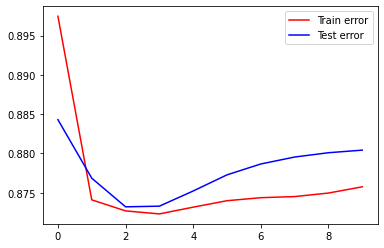

In [ ]:
plt.plot(train_mse,color ="red", label = "Train error")
plt.plot(test_mse,color = "blue", label = "Test error")
plt.legend(loc = "best")

In [ ]:
train_rmse = min(train_mse)
test_rmse = min(test_mse)
print("Train RMSE is : {} and Test RMSE : {}".format(train_rmse,test_rmse))

Train RMSE is : 0.8722978566079136 and Test RMSE : 0.8732010118966119


#Memory-Based

In [ ]:
movies['movie_id'] = movies['movie_id'].apply(lambda x: x + 1)
users['user_id'] = users['user_id'].apply(lambda x: x + 1)
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: x + 1)
ratings['user_id'] = ratings['user_id'].apply(lambda x: x + 1)

In [ ]:
#Create the rating matrix with rows as movies and columns as users.
train_ratings_mat = np.zeros(
    shape=(np.max(ratings.user_id.values), np.max(ratings.movie_id.values)),
    dtype=np.float64)

train_ratings_mat[train_data.user_id.values, train_data.movie_id.values] = train_data.rating.values

test_ratings_mat = np.zeros(
    shape=(np.max(ratings.user_id.values), np.max(ratings.movie_id.values)),
    dtype=np.float64)

test_ratings_mat[test_data.user_id.values, test_data.movie_id.values] = test_data.rating.values

##User-Based

In [ ]:
n_user = np.max(ratings.user_id.values)
nonzero_ind=[]
for i in range(n_user):
  nonzero_ind.append(list(np.array(train_ratings_mat[i]).nonzero()))

In [ ]:
def cosine_similarity(a, b):
  x=nonzero_ind[a]
  y=nonzero_ind[b]
  ind=np.intersect1d(x,y)
  A=train_ratings_mat[a][ind]
  B=train_ratings_mat[b][ind]
  cosine = np.dot(A,B)/(norm(A)*norm(B))
  return cosine

In [ ]:
user_sim = np.zeros(shape=(np.max(n_user), np.max(n_user)),dtype=np.float64)

for i in range(n_user):
  for j in range(i):
    user_sim[i][j]=cosine_similarity(i,j)
    user_sim[j][i]=user_sim[i][j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [ ]:
def predict_rating(user, movie,k):
  us = user_sim[user-1]
  user_rank=np.argsort(us)[::-1]
  i=0
  rat=[]
  for ind in user_rank:
    if (us[ind]>0) and (train_ratings_mat[ind][movie-1]>0):
      rat.append(train_ratings_mat[ind][movie-1])
      i+=1
    if i>k:
      break
  if rat==[]:
    rat=train_data.rating.values.mean()
  return np.mean(rat)

In [ ]:
def rmse(df,k):
    '''calculates net rmse'''
    y_true = []
    y_pred = []
    for user,movie,rate in df[['user_id','movie_id','rating']].values:
        y_hat=predict_rating(user,movie,k)
        y_true.append(rate)
        y_pred.append(y_hat)
    #ymin=min(y_pred)
    #ymax=max(y_pred)
    #y_pred=(y_pred-ymin)/(ymax-ymin)*4+1
    return mean_squared_error(y_true,y_pred)

In [ ]:
train_total_error=[]
test_total_error=[]
for i in ([3,5,10,20]):
  train_error=rmse(train_data,i)
  test_error=rmse(test_data,i)
  train_total_error.append(train_error)
  test_total_error.append(test_error)

KeyboardInterrupt: ignored

ValueError: ignored

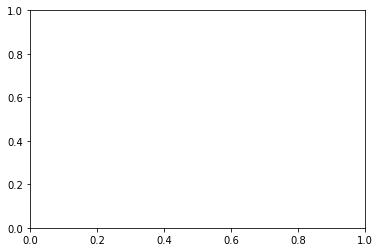

In [ ]:
plt.plot([3,5,10,20],train_total_error,color ="red", label = "Train error")
plt.plot([3,5,10,20],test_total_error,color ="blue", label = "Test error")
plt.legend(loc = "best")

##Item-Based

In [ ]:
n_movie = np.max(ratings.movie_id.values)
nonzero_ind_m=[]
for i in range(n_movie):
  nonzero_ind_m.append(list(np.array(train_ratings_mat[:,i]).nonzero()))

In [ ]:
def cosine_similarity_m(a, b):
  x=nonzero_ind_m[a]
  y=nonzero_ind_m[b]
  ind=np.intersect1d(x,y)
  A=train_ratings_mat[:,a][ind]
  B=train_ratings_mat[:,b][ind]
  cosine = np.dot(A,B)/(norm(A)*norm(B))
  return cosine

In [ ]:
movie_sim = np.zeros(shape=(np.max(n_movie), np.max(n_movie)),dtype=np.float64)

for i in range(n_movie):
  for j in range(i):
    movie_sim[i][j]=cosine_similarity_m(i,j)
    movie_sim[j][i]=movie_sim[i][j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [ ]:
def predict_rating_m(user, movie,k):
  ms = movie_sim[movie-1]
  movie_rank=np.argsort(ms)[::-1]
  i=0
  rat=[]
  for ind in movie_rank:
    if (ms[ind]>0) and (train_ratings_mat[user-1][ind]>0):
      rat.append(train_ratings_mat[user-1][ind])
      i+=1
    if i>k:
      break
  if rat==[]:
    rat=train_data.rating.values.mean()
  return np.mean(rat)

In [ ]:
def rmse_m(df,k):
    '''calculates net rmse'''
    y_true = []
    y_pred = []
    for user,movie,rate in df[['user_id','movie_id','rating']].values:
        y_hat=predict_rating_m(user,movie,k)
        y_true.append(rate)
        y_pred.append(y_hat)
    return mean_squared_error(y_true,y_pred)

In [ ]:
train_total_error_m=[]
test_total_error_m=[]
for i in ([3,5,10,20]):
  train_error=rmse_m(train_data,i)
  test_error=rmse_m(test_data,i)
  train_total_error_m.append(train_error)
  test_total_error_m.append(test_error)

In [ ]:
plt.plot([3,5,10,20],train_total_error_m,color ="red", label = "Train error")
plt.plot([3,5,10,20],test_total_error_m,color ="blue", label = "Test error")
plt.legend(loc = "best")